In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import grid_evaluate
from sklearn.neural_network import MLPClassifier


#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')


#Squeeze to make them series
y_train = y_train.squeeze()
y_test = y_test.squeeze()


#Define the base model
base_clf = MLPClassifier(
    max_iter=1000,
    random_state=42
)


param_grid = {

    'hidden_layer_sizes': [(15,), (20,), (15,15)],
    'activation':         ['relu', 'tanh'],
    'alpha':              [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #L2 penalty (weight decay)
    'learning_rate_init': [1e-3, 1e-2],
}


results_nn = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)

#drop unnecessary columns (not modified in neural network model)
results_nn = results_nn.drop(
    columns=['feature_method','degree','n_components','gamma'],
    errors='ignore'   # won’t error out if any are already missing
)

#Inspect best model by F1
best_nn = results_nn.sort_values('f1_score', ascending=False)
print(best_nn.iloc[0])
print(best_nn)


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_m

accuracy                 0.728
precision             0.448276
recall                0.419355
f1_score              0.433333
activation                relu
alpha                    0.001
hidden_layer_sizes    (15, 15)
learning_rate_init        0.01
Name: 23, dtype: object
    accuracy  precision    recall  f1_score activation     alpha  \
23     0.728   0.448276  0.419355  0.433333       relu  0.001000   
28     0.724   0.438596  0.403226  0.420168       relu  0.010000   
22     0.728   0.444444  0.387097  0.413793       relu  0.001000   
10     0.728   0.444444  0.387097  0.413793       relu  0.000010   
4      0.724   0.436364  0.387097  0.410256       relu  0.000001   
..       ...        ...       ...       ...        ...       ...   
25     0.644   0.278689  0.274194  0.276423       relu  0.010000   
53     0.636   0.262295  0.258065  0.260163       tanh  0.000100   
47     0.632   0.258065  0.258065  0.258065       tanh  0.000010   
41     0.632   0.258065  0.258065  0.258065     

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


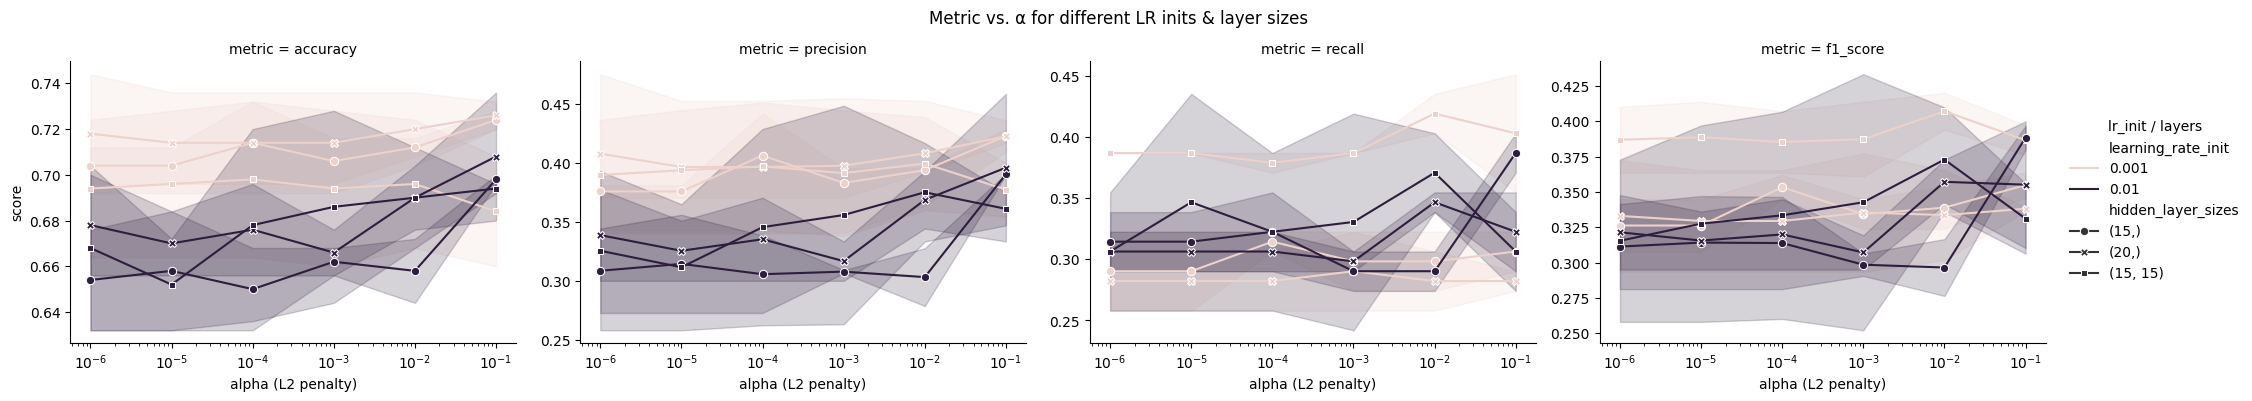

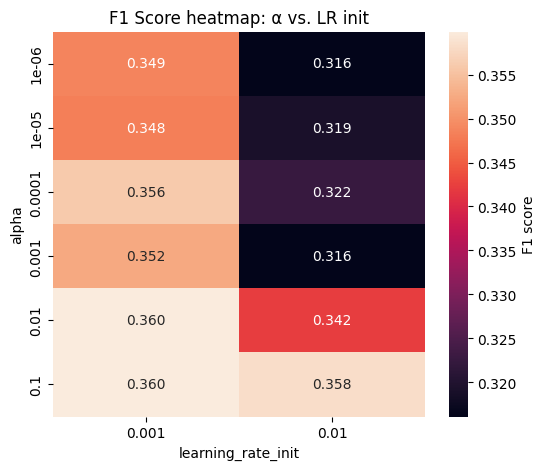

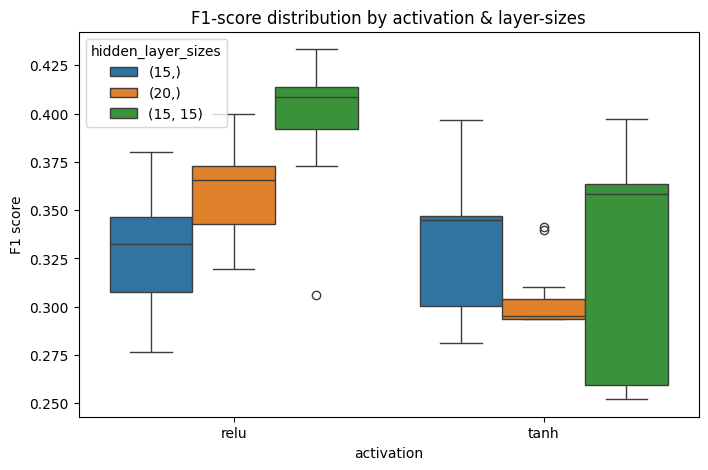

In [2]:

df = results_nn.reset_index(drop=True)


#melting df for easier plotting
metrics = ['accuracy','precision','recall','f1_score']
df_long = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

#using sns to visualize the results
g = sns.FacetGrid(
    df_long, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='lr_init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different LR inits & layer sizes')
plt.show()


#heatmap of F1-score over (alpha, learning_rate_init)

pivot_f1 = df.pivot_table(
    index='alpha', 
    columns='learning_rate_init', 
    values='f1_score'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    pivot_f1, 
    annot=True, 
    fmt=".3f", 
    cbar_kws={'label':'F1 score'}
)
plt.title('F1 Score heatmap: α vs. LR init')
plt.xlabel('learning_rate_init')
plt.ylabel('alpha')
plt.show()


#activation comparison
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_long[df_long.metric=='f1_score'],
    x='activation',
    y='score',
    hue='hidden_layer_sizes'
)
plt.title('F1-score distribution by activation & layer-sizes')
plt.ylabel('F1 score')
plt.show()
